<a href="https://colab.research.google.com/github/RonTeichner/IRAS/blob/main/IRAS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Identifying Regulation with Adversarial Surrogate**

In the following example IRAS algorithm is evaluated over time-series observations obtained from the Lotka-Volterra dynamical system,
$$
\begin{equation}
\begin{split}
\dot{x} &= \alpha x - \beta x y\\
\dot{y} &= \delta x y - \gamma y.
\end{split}
\end{equation}
$$
The obtained observations $z(t)$ are the numbers of predator and prey corrupted by additive white noise $n(t) \in \mathbb{R}^2$,
$$
\begin{equation}
z(t) \overset{\Delta}{=} \begin{bmatrix} z_1(t) \\ z_2(t)\end{bmatrix} = \begin{bmatrix}x(t) \\ y(t)\end{bmatrix} + n(t).
\end{equation}
$$

The Lotka-Volterra model has an conserved quantity,
$$
\begin{equation}
{\cal{V}}(x,y) = \delta x - \gamma \log(x) + \beta y - \alpha \log(y)
\end{equation}
$$
which should be correctly identified by IRAS, yielding the learned combination,
$$
\begin{equation}
g(z) = \delta z_1 - \gamma \log(z_1) + \beta z_2 - \alpha \log(z_2).
\end{equation}
$$

In what follows we


1.   Create a dataset of $M$ time-series observations ${\cal{D}}=\{z^{(s)}(t)\}_{s=0}^{M-1}$
2.   Run the IRAS algorithm over ${\cal{D}}$
3.   Examine the Pearson correlation between ${\cal{V}}(x,y)$ and the learned combination $g(z)$. A high correlation testifies that the conserved quantity ${\cal{V}}$ was successfully learned.

## Generating observations from the Lotka-Volterra model
In the following code we create observations for 20 time-series from the Lotka-Volterra model with parameters, $(\alpha,\beta,\gamma,\delta)=(0.2, 0.025, 0.1, 0.02)$ and initial conditions $x_0 \sim U[4,5]$, $y_0 \sim U[7,8]$. The models are integrated from $t=0$ to $t=500$ using *solve_ivp* from *scipy* to obtain $x(t)$ and $y(t)$. Then, $z(t)$ is a noissy observation of $x,y$.



In [13]:
from scipy.integrate import solve_ivp
import numpy as np

def lotkavolterra(t, z, a, b, c, d):
    x, y = z
    return [a*x - b*x*y, -c*y + d*x*y]

def lotkavolterra_jac(t, z, a, b, c, d):
    x, y = z
    return np.array([[a-b*y, -b*x], [d*y, -c+d*x]])

def createSys(T, lotkavolterra, lotkavolterra_jac, SNR, factor):
    simTimes = [0, T]
    rtol = 1e-12
    method = 'Radau'
    fs = 1
    isnan = True
    while isnan:
        params = (0.2, 0.025, 0.1, 0.02)        
        a,b,c,d = params
        factor = 1
        x0, y0 = 4 + factor*np.random.rand(), 7 + factor*np.random.rand()
       
        sol = solve_ivp(lotkavolterra, simTimes, [x0, y0], args=params, dense_output=True, method=method, jac=lotkavolterra_jac, rtol=rtol)
        t = np.linspace(0, T, int(fs*T))
        z = sol.sol(t)
        
        noiseStd = np.sqrt(np.power(z,2).mean()/SNR)
        noise = noiseStd*np.random.randn(z.shape[1])
        
        dot_z = np.asarray(lotkavolterra(0, z, a, b, c, d))
        unitParallelVec = np.divide(dot_z, np.linalg.norm(dot_z, axis=0)[None,:].repeat(2,0))
        unitOrthogonalVec = np.zeros_like(unitParallelVec)
        unitOrthogonalVec[0] = -unitParallelVec[1]
        unitOrthogonalVec[1] = unitParallelVec[0]        
        unitOrthogonalVec = np.divide(unitOrthogonalVec, np.linalg.norm(unitOrthogonalVec, axis=0)[None,:].repeat(2,0))
        OrthogonalNoise = unitOrthogonalVec*noise[None, :].repeat(2,0)
        OrthogonalNoise = OrthogonalNoise * (np.random.randint(low=0, high=2, size=unitOrthogonalVec.shape[1])*2-1)[ None,:].repeat(2,0)
        
        z = z + OrthogonalNoise        
        x, y = z.T[:,0], z.T[:,1]
        V = d*x - c*np.log(x) + b*y - a*np.log(y)
        if not(np.isnan(V).any()):
            isnan = False
    return (a,b,c,d, t, z, V)

factor = 0.01
nSys = 20
T = 500 # [sec]
springSysList = list()
for i in range(nSys):    
    springSysList.append(createSys(T, lotkavolterra,lotkavolterra_jac, SNR=10000, factor=factor))

tVec = springSysList[0][4]
nSamples = tVec.shape[0]
observations = np.zeros((nSys, nSamples, 2))
V = np.zeros((nSys, nSamples))
for s in range(len(springSysList)):
    observations[s,:,0] = springSysList[s][5][0]
    observations[s,:,1] = springSysList[s][5][1]
    V[s,:] = springSysList[s][6]

Now we can print the trajectory and $(x,y)$ phase space for one observed system,

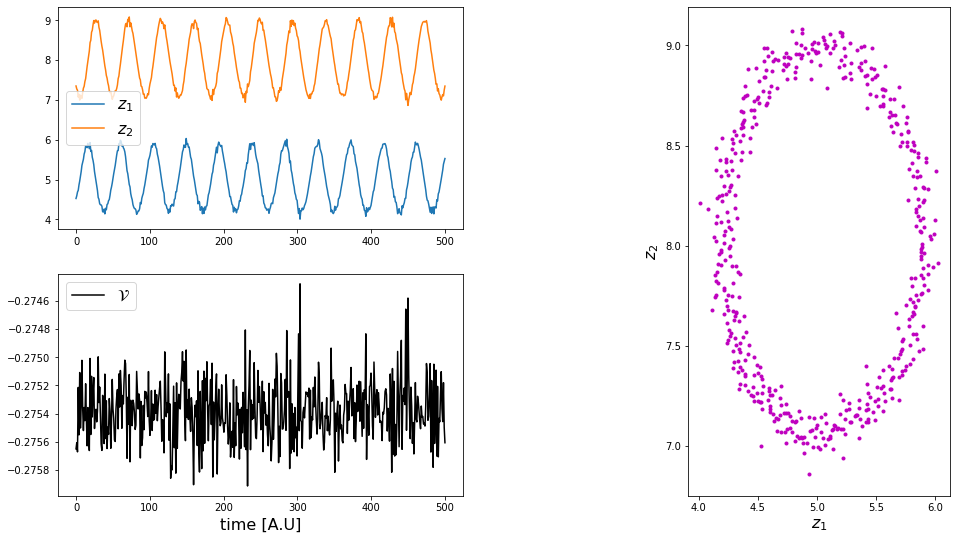

In [14]:
import matplotlib.pyplot as plt

systemIdx = 0
z1 = observations[systemIdx,:,0]
z2 = observations[systemIdx,:,1]
v = V[systemIdx]

plt.figure(figsize=(16,9))
fontsize=16
plt.subplot(2,2,1)
plt.plot(tVec,z1,label=r'$z_1$')
plt.plot(tVec,z2,label=r'$z_2$')
plt.legend(fontsize=fontsize)
plt.subplot(2,2,3)
plt.plot(tVec,v,'k',label=r'${\cal{V}}$')
plt.legend(fontsize=fontsize)
plt.xlabel('time [A.U]',fontsize=fontsize)
plt.subplot(1,3,3)
plt.plot(z1,z2,'m.')
plt.xlabel(r'$z_1$',fontsize=fontsize)
plt.ylabel(r'$z_2$',fontsize=fontsize)
plt.show()

## Define the neural-network $g(z)$
Next we define the neural-network $g: \mathbb{R}^2 → \mathbb{R}$ that will output a combination,
$$
\begin{equation}
  c = g(z_1,z_2)
\end{equation}
$$
for each observation $(z_1,z_2)$.